<a href="https://colab.research.google.com/github/Adlucent/ga4-churn-prediction/blob/main/IV_Defining_the_Churn_Target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IV. Defining the Churn Target

In this notebook, we'll define the churn target for use in our model. 

1. Aggregate customer revenue by day
2. Calculate the moving average for each customer over the last 28 days
3. Calculate the 56 day standard deviation of the moving average (this and the following step are only needed if you're distinguishing between soft and hard churn - see below for explanations)
4. Define a minimum threshold ((28 day Moving Average - (56 day standard deviation * 2))
5. Split the data by event date into two tables: one containing only activity from prior to the cutoff date defined in a previous notebook, and the other containing only data from after that cutoff date.
6. We'll assign the churn label based on which customers who are still active (not churned yet) as of the cutoff date have a moving average that falls to zero in the post-cutoff df.
*Note that the values in the above steps will vary depending on the typical purchase cycle for your customers. You may want to experiment with a few different time lengths, as long as you ensure the ratios between the values stay the same.*

How we know a customer has churned:
* When the moving average falls under the threshold, the customer is churned. 
* Soft churn is when the moving average goes below the minimum threshold defined by us.
* Hard churn is when the moving avg reaches zero. 
* For our purposes, we are adding segments for churn types, but not differentiating between them in the Churn Target column.

## Import libraries

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

project_name = 'adl-analytics' #add proj name
region = "US"  # GCP project region

In [ ]:
# Google credentials 
from google.colab import auth
auth.authenticate_user()

# BigQuery Magics 
'''BigQuery magics are used to run BigQuery SQL queries in a python environment.
These queries can also be run in the BigQuery UI '''

from google.cloud import bigquery
from google.cloud.bigquery import magics, Client, QueryJobConfig

magics.context.project = project_name
client = bigquery.Client(project=magics.context.project)

# data processing
import pandas as pd
import numpy as np
from datetime import timedelta

# statistical calculations
from scipy import stats

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# suppress notebook warnings
import warnings
warnings.filterwarnings('ignore')

# dataframe formatting
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

## Load Data from BigQuery

From the original dataset, load data for purchases only. In defining churn, we only care about customers' actual purchase events.

In [ ]:
%%bigquery data --project $project_name
SELECT user_pseudo_id,event_date,ecommerce
FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
WHERE event_name = "purchase"

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
# make a copy in case we need to revert back to original table at any point
df = data.copy()

In [ ]:
df.head()

,user_pseudo_id,event_date,ecommerce
0,1245203.1205410719,20201223,"{'total_item_quantity': 1, 'purchase_revenue_i..."
1,1685178.0670336190,20201223,"{'total_item_quantity': 1, 'purchase_revenue_i..."
2,3577806.2578587674,20201223,"{'total_item_quantity': 1, 'purchase_revenue_i..."
3,4707239.1008432127,20201223,"{'total_item_quantity': 1, 'purchase_revenue_i..."
4,4997326.4756259004,20201223,"{'total_item_quantity': 1, 'purchase_revenue_i..."


## Set cutoff date and filter out post-cutoff data

In [ ]:
# convert even_date feature to datetime dtype
df["event_date"] = pd.to_datetime(df["event_date"])

In [ ]:
# set Cutoff Date at 28 days prior to the end of the data set range; update this value if you're using different time lengths
cutoff_date = df["event_date"].max() - timedelta(days=28)
print(cutoff_date)

2021-01-03 00:00:00


## Unnest `ecommerce` column to get purchase revenue

In [ ]:
df = pd.concat([df, df["ecommerce"].apply(pd.Series)], axis=1)
df.drop(columns="ecommerce", axis=1, inplace=True)

In [ ]:
# inpect top 5 rows of df
df.head()

,user_pseudo_id,event_date,total_item_quantity,purchase_revenue_in_usd,purchase_revenue,refund_value_in_usd,refund_value,shipping_value_in_usd,shipping_value,tax_value_in_usd,tax_value,unique_items,transaction_id
0,1245203.1205410719,2020-12-23,1.000,55.000,55.000,NaN,NaN,NaN,NaN,6.000,6.000,1.000,574807
1,1685178.0670336190,2020-12-23,1.000,92.000,92.000,NaN,NaN,NaN,NaN,9.000,9.000,1.000,335627
2,3577806.2578587674,2020-12-23,1.000,22.000,22.000,NaN,NaN,NaN,NaN,3.000,3.000,1.000,26005
3,4707239.1008432127,2020-12-23,1.000,44.000,44.000,NaN,NaN,NaN,NaN,0.000,0.000,1.000,396331
4,4997326.4756259004,2020-12-23,1.000,19.000,19.000,NaN,NaN,NaN,NaN,2.000,2.000,1.000,20653


## Create our table for defining the target

Isolate columns required for defining churn and drop duplicate rows. Columns to keep:
- `user_pseudo_id`
- `transaction_id`
- `event_date`
- `purchase_revenue_in_usd`

In [ ]:
df = df[
    ["user_pseudo_id", "transaction_id","event_date", "purchase_revenue_in_usd"]
].drop_duplicates(subset=None, keep="first")

Group by `user_pseudo_id` and `event_date`, and sum `purchase_revenue_in_usd`

In [ ]:
df = df.groupby(["user_pseudo_id", "event_date"]).agg(
    {
        "purchase_revenue_in_usd": "sum",
    }
)
df.reset_index(inplace=True)

In [ ]:
df.head()

,user_pseudo_id,event_date,purchase_revenue_in_usd
0,10092926.3786306416,2021-01-22,90.000
1,10111055.8768683862,2020-12-10,94.000
2,1014825.0200289249,2020-11-03,183.000
3,1016446.8237887674,2020-12-21,86.000
4,10172849.5375293351,2020-12-09,156.000


Check the distribution of `purchase_revenue_in_usd`

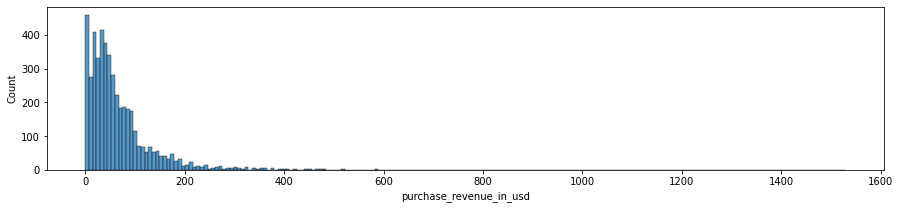

In [ ]:
plt.figure(figsize=(15,3))
sns.histplot(data = df,x = "purchase_revenue_in_usd");

### Sort records in ascending order by user in preparation for building a true time series

In [ ]:
idx = pd.MultiIndex.from_product(
    (df["event_date"], df["user_pseudo_id"].unique()),
    names=["event_date", "user_pseudo_id"],
)

### Fill in missing dates and assign values of 0

To calculate moving averages, we need to have every day accounted for in the table for each user, not just rows with purchase activity.

In [ ]:
df = (
    df.set_index(["event_date", "user_pseudo_id"])
    .reindex(idx, fill_value=0)
    .reset_index()
    .sort_values(by=["user_pseudo_id", "event_date"], ascending=[True, True])
    .reset_index(drop=True)
)

In [ ]:
# drop potential duplicates; it's good practice to do this to be sure the data is clean
df = df[
    ["user_pseudo_id", "event_date", "purchase_revenue_in_usd"]
].drop_duplicates(subset=None, keep="first")

In [ ]:
# spot check the df
df.head()

,user_pseudo_id,event_date,purchase_revenue_in_usd
0,10092926.3786306416,2020-11-01,0.000
13,10092926.3786306416,2020-11-02,0.000
52,10092926.3786306416,2020-11-03,0.000
98,10092926.3786306416,2020-11-04,0.000
128,10092926.3786306416,2020-11-05,0.000


### Calculate 28-day moving average for each customer and add as a column

In [ ]:
# calculate 28-day moving average for each customer
df["28ma"] = df.groupby("user_pseudo_id")[
    "purchase_revenue_in_usd"
].transform(lambda x: x.rolling(28, 1).mean())

### Calculate 56-day standard deviation of the 28-day MA and add as a column

In [ ]:
# calculate 56-day standard deviation of the 28-day moving average for each customer
df["56sd"] = df.groupby("user_pseudo_id")["28ma"].transform(
    lambda x: x.rolling(56, 1).std()
)

### Define lower thresholds

In [ ]:
df["threshold"] = df["28ma"] - (df["56sd"] * 2)

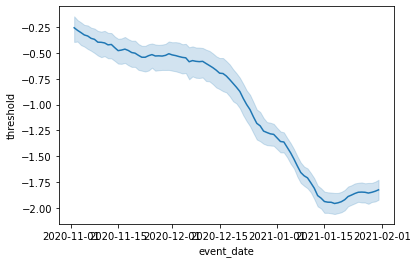

In [ ]:
sns.lineplot(x="event_date", y="threshold", data=df);

## Split data into pre and post cutoff dates

In [ ]:
df_pre_cutoff = pd.DataFrame(df.loc[df["event_date"] < cutoff_date])
df_post_cutoff = pd.DataFrame(df.loc[df["event_date"] >= cutoff_date])

### Define Churn conditions

In [ ]:
soft_churn = np.where(df_pre_cutoff["28ma"] < df_pre_cutoff["threshold"])
churn = df_pre_cutoff["28ma"] == 0

### Set Churn Column

We're adding a column that labels each row as either True or False (for Churned), meaning the moving average is either at or above 0.

In [ ]:
df_pre_cutoff["Churned"] = np.where(
    df_pre_cutoff["28ma"] < df_pre_cutoff["threshold"], True, False
)
df_pre_cutoff["Churned"] = np.where(df_pre_cutoff["28ma"] == 0, True, False)

### Label Churn Type

Next we'll add a column to indicate whether each row represents a soft or hard churn.

In [ ]:
df_pre_cutoff["Churn_Type"] = np.where(
    df_pre_cutoff["28ma"] < df_pre_cutoff["threshold"], "Soft", "None"
)
df_pre_cutoff["Churn_Type"] = np.where(df_pre_cutoff["28ma"] == 0, "Hard", "None")

In [ ]:
print(df_pre_cutoff["Churned"].value_counts())
print("*" * 50)
print(df_pre_cutoff["Churn_Type"].value_counts())

True     197129
False     81268
Name: Churned, dtype: int64
**************************************************
Hard    197129
None     81268
Name: Churn_Type, dtype: int64


As shown above, there are no soft churn values in this dataset. This is likely because there are few customers in the table who have placed more than one purchase. In a real dataset containing more data, there will likely be values for both hard and soft churn due to more fluctuations in the moving averages per user.

For purposes of our model, we'll only use Hard churn, and label churn as a True/False value. If you'd like to distinguish between Soft Churn, Hard Churn, and No Churn, you can create a multi-class classification model instead of the binary classification steps outlined in this notebook.

## Next, revisit the post-event table

In [ ]:
df_post_cutoff.head()

,user_pseudo_id,event_date,purchase_revenue_in_usd,28ma,56sd,threshold
3712,10092926.3786306416,2021-01-03,0.000,0.000,0.000,0.000
3726,10092926.3786306416,2021-01-04,0.000,0.000,0.000,0.000
3742,10092926.3786306416,2021-01-05,0.000,0.000,0.000,0.000
3769,10092926.3786306416,2021-01-06,0.000,0.000,0.000,0.000
3797,10092926.3786306416,2021-01-07,0.000,0.000,0.000,0.000


Add a Churned column to the post-cutoff table.

In [ ]:
df_post_cutoff["Churned"] = np.where(df_post_cutoff["28ma"] == 0, True, False)

In [ ]:
# filter for the most recent row in the post cutoff table to get each customer's churned status at the end of the post cutoff period
df_post_last_record = df_post_cutoff.loc[df_post_cutoff.groupby('user_pseudo_id')['event_date'].idxmax()]

In [ ]:
# reset index
df_post_last_record.reset_index(drop=True,inplace=True)

In [ ]:
# isolate only the user id, 28ma, and Churned columns for use in the next step
df_post_churned = df_post_last_record[["user_pseudo_id","28ma","Churned"]].copy()

In [ ]:
df_post_churned.head()

,user_pseudo_id,28ma,Churned
0,10092926.3786306416,3.214,False
1,10111055.8768683862,0.000,True
2,1014825.0200289249,0.000,True
3,1016446.8237887674,0.000,True
4,10172849.5375293351,0.000,True


### Filter pre-event df for most recent row per customer to see if they're active or already churned

In [ ]:
df_pre_last_record = df_pre_cutoff.loc[df_pre_cutoff.groupby('user_pseudo_id')['event_date'].idxmax()]

In [ ]:
# reset index
df_pre_last_record.reset_index(drop=True,inplace=True)

### Merge churn labels from post-cutoff table onto the pre-cutoff last record table

In [ ]:
df_churn = pd.merge(df_pre_last_record, df_post_churned, how='left', on = 'user_pseudo_id')

In [ ]:
df_churn.head()

,user_pseudo_id,event_date,purchase_revenue_in_usd,28ma_x,56sd,threshold,Churned_x,Churn_Type,28ma_y,Churned_y
0,10092926.3786306416,2021-01-02,0.000,0.000,0.000,0.000,True,Hard,3.214,False
1,10111055.8768683862,2021-01-02,0.000,3.357,1.676,0.004,False,None,0.000,True
2,1014825.0200289249,2021-01-02,0.000,0.000,6.306,-12.613,True,Hard,0.000,True
3,1016446.8237887674,2021-01-02,0.000,3.071,1.308,0.454,False,None,0.000,True
4,10172849.5375293351,2021-01-02,0.000,5.571,2.795,-0.018,False,None,0.000,True


### Set customer labels

In [ ]:
# customer pre-event status labels
def custLabelsPre(row):
    if row['Churned_x'] == True:   
        val = 'Inactive'
    
    else:
        val = 'Active'
        
    return val

In [ ]:
df_churn["pre_cutoff_status"] = df_churn.apply(custLabelsPre,axis=1)

In [ ]:
# customer post-event status labels
def custLabelsPost(row):
    if row['Churned_y'] == False:   
        val = 'Active'
    
    else:
        val = 'Inactive'
        
    return val

In [ ]:
df_churn["post_cutoff_status"] = df_churn.apply(custLabelsPost,axis=1)

## Adding Churn Target Column

In [ ]:
# adding churn target label
def ChurnTarget(row):
    if row['pre_cutoff_status'] == "Active" and row['post_cutoff_status'] == "Inactive":   
        val = "True"
        
    elif row['pre_cutoff_status'] == "Active" and row['pre_cutoff_status'] == "Active":   
        val = "False"
    
    else:
        val = 'Inactive'
        
    return val

In [ ]:
df_churn["Churn_Target"] = df_churn.apply(ChurnTarget,axis=1)

In [ ]:
df_churn["Churn_Target"].value_counts()

Inactive    2849
True        1540
False         30
Name: Churn_Target, dtype: int64

As shown above, the majority of customers in the dataset are churners during the post-event period. This makes our dataset imbalanced, meaning we'll need to do some additional pre-work in later steps before building the model.

## Check the table one more time and then savie to BigQuery for use later in reporting

In [ ]:
df_churn.head()

,user_pseudo_id,event_date,purchase_revenue_in_usd,28ma_x,56sd,threshold,Churned_x,Churn_Type,28ma_y,Churned_y,pre_cutoff_status,post_cutoff_status,Churn_Target
0,10092926.3786306416,2021-01-02,0.000,0.000,0.000,0.000,True,Hard,3.214,False,Inactive,Active,Inactive
1,10111055.8768683862,2021-01-02,0.000,3.357,1.676,0.004,False,None,0.000,True,Active,Inactive,True
2,1014825.0200289249,2021-01-02,0.000,0.000,6.306,-12.613,True,Hard,0.000,True,Inactive,Inactive,Inactive
3,1016446.8237887674,2021-01-02,0.000,3.071,1.308,0.454,False,None,0.000,True,Active,Inactive,True
4,10172849.5375293351,2021-01-02,0.000,5.571,2.795,-0.018,False,None,0.000,True,Active,Inactive,True


In [ ]:
# rename column headers to make compatible with BigQuery table schema requirements 
df_churn.rename(columns={"28ma_x": "pre_MA", "56sd": "pre_SD", "28ma_y": "post_MA"}, inplace=True)

In [ ]:
client = bigquery.Client(project = project_name)
table_id = 'public_sample_data.churn_ga4_target_details' # update with your dataset and table name

job_config = bigquery.LoadJobConfig(
    write_disposition = bigquery.job.WriteDisposition.WRITE_TRUNCATE
)

job = client.load_table_from_dataframe(
    df_churn, table_id, job_config = job_config
)

# Wait for the load job to complete.
job.result()

LoadJob<project=adl-analytics, location=US, id=d0e399f6-4f35-4ace-9d72-9742962db585>

### Create a separate table containing only the `pseudo_user_id` and `Churn_Target` for customers who are still active

This creates an index for our Churn Target column that we'll add later to our full training dataset. 

In [ ]:
## select only user_pseudo_id and Churn_Target columns
df_churn_target = df_churn.loc[df_churn["Churn_Target"] != "Inactive"]
df_churn_target = df_churn_target[
    [
        "user_pseudo_id",
        "Churn_Target"
    ]
].copy()

In [ ]:
# convert target values to 1 and 0 
replaceStruct = {
    "Churn_Target": {
        "True": 1,
        "False": 0,    
    },
}
df_churn_target = df_churn_target.replace(replaceStruct)

In [ ]:
df_churn_target["Churn_Target"].value_counts()

1    1540
0      30
Name: Churn_Target, dtype: int64

In [ ]:
df_churn_target["user_pseudo_id"].nunique()

1570

## Store table in BigQuery

In [ ]:
client = bigquery.Client(project = project_name)
table_id = 'public_sample_data.churn_ga4_4' # update with your dataset and table name

job_config = bigquery.LoadJobConfig(
    write_disposition = bigquery.job.WriteDisposition.WRITE_TRUNCATE
)

job = client.load_table_from_dataframe(
    df_churn_target, table_id, job_config = job_config
)

# Wait for the load job to complete.
job.result()

LoadJob<project=adl-analytics, location=US, id=c278922f-029c-491f-9ace-62b00e339683>